# Ejercicio de GLM

# 1. INTRO: Repaso

La **regresión logística (logit)** es un modelo para **clasificación binaria** (dos clases, 0/1). En vez de predecir directamente la clase, calcula un **score** de pertenecer a la clase 1.

Para lograr que esa salida esté siempre entre **0 y 1**, el modelo toma una combinación lineal de las variables (una “puntuación” o *score*) y la pasa por una función en forma de “S” llamada **sigmoide**: si el score sube, la probabilidad se acerca a 1; si baja, se acerca a 0.

Además, el logit trabaja con las **odds** (la razón entre “probabilidad de que ocurra” y “probabilidad de que no ocurra”): cada coeficiente indica cómo cambian esas odds cuando una variable aumenta, manteniendo las demás constantes, y al hacer `exp(coef)` obtienes un **odds ratio** (un multiplicador fácil de interpretar).


# 1.1 Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, log_loss, precision_score, recall_score, f1_score,
    precision_recall_curve, auc
)

np.random.seed(42)

# 1.2 Cargamos los datos (dataset predicción cancer de mama)

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign

In [3]:
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
y

,target
0,0
1,0
2,0
3,0
4,0
...,...
564,0
565,0
566,0
567,0


# 1.3 Breve EDA

In [5]:
df = X.copy()
df["target"] = y

In [6]:
print("Shape:", df.shape)
print("\nPrimeras filas:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nNulos por columna:")
print(df.isna().sum())

print("\nDuplicados:", df.duplicated().sum())

print("\nDistribución del target (0=malignant, 1=benign):")
print(df["target"].value_counts())
print("\nProporciones:")
print(df["target"].value_counts(normalize=True).round(3))

print("\nDescribe (numérico):")
print(df["target"].describe().T)

Shape: (569, 31)

Primeras filas:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perim

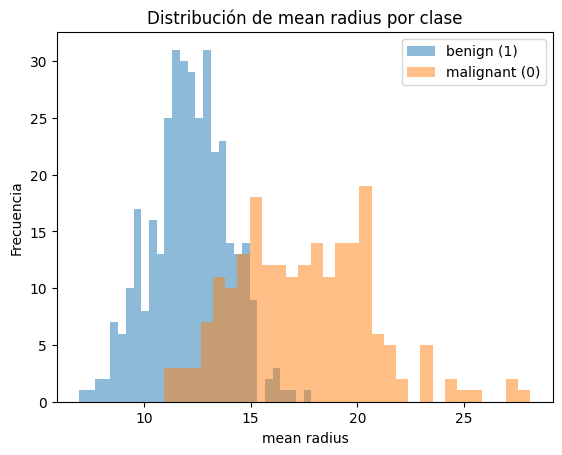

In [7]:
# 1) Histogramas por clase
plt.figure()
benign = df[df["target"] == 1]["mean radius"]
malignant = df[df["target"] == 0]["mean radius"]
plt.hist(benign, bins=30, alpha=0.5, label="benign (1)")
plt.hist(malignant, bins=30, alpha=0.5, label="malignant (0)")
plt.title(f"Distribución de mean radius por clase")
plt.xlabel("mean radius")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

/tmp/ipython-input-800646040.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=["malignant (0)", "benign (1)"])


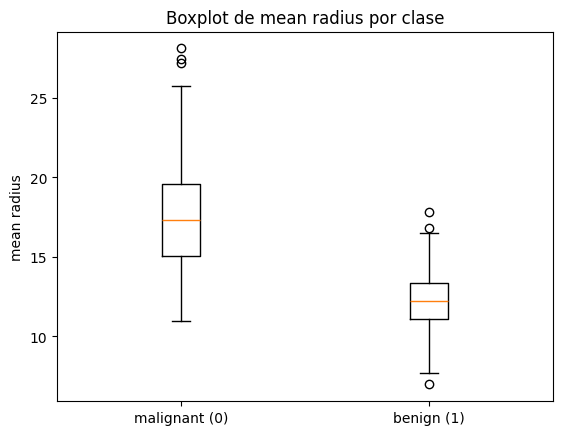

In [8]:
# 2) Boxplot por clase (rápido para ver separación y outliers)
plt.figure()
data_to_plot = [
    df[df["target"] == 0]["mean radius"].values,  # malignant
    df[df["target"] == 1]["mean radius"].values   # benign
]
plt.boxplot(data_to_plot, labels=["malignant (0)", "benign (1)"])
plt.title(f"Boxplot de mean radius por clase")
plt.ylabel("mean radius")
plt.show()

<Axes: >

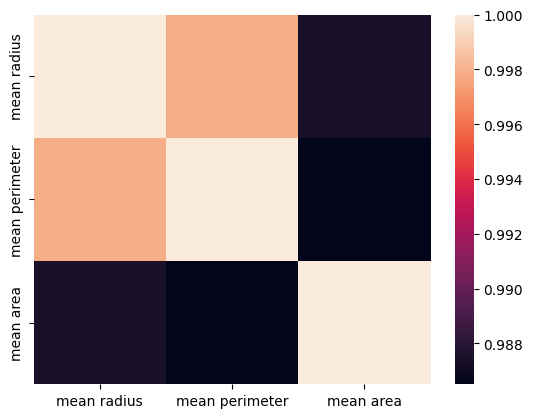

In [9]:
# 3) Correlaciones (muy importante para entender coeficientes raros)
corr = df[["mean radius","mean perimeter","mean area"]].corr()
sns.heatmap(corr)

# 1.4 Seleccionar features y separar en train-test

In [10]:
# Seleccionamos algunas features para entrenar un primer modelo
features = [
    "mean radius",
    "mean texture",
    "mean perimeter",
    "mean area",
    "mean smoothness",
]

In [11]:
# Nos quedamos con las features seleccionadas
X_sel = X[features].copy()

In [13]:
# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y,
    test_size=0.25,
    random_state=42 #para que sea reproducible, siempre hay que ponerlo!
)

# 1.5 Preprocesamiento

In [14]:
# Escalamos las variables para que estén en la misma escala
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=features, index=X_train.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test), columns=features, index=X_test.index)

# Con la librería statsmodels tenemos que añadir manualmente el intercepto
X_train_c = sm.add_constant(X_train_s, has_constant="add")
X_test_c  = sm.add_constant(X_test_s,  has_constant="add")

# 1.6 Entrenamiento del modelo

In [15]:
# Definimos un GLM con una función de unión Logit (de la familia binomial)
model = sm.GLM(
    y_train,
    X_train_c,
    family=sm.families.Binomial(link=sm.families.links.logit())
)
# Entrenamos
model_fitted = model.fit()
print(model_fitted.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  426
Model:                            GLM   Df Residuals:                      420
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -69.579
Date:                Wed, 04 Feb 2026   Deviance:                       139.16
Time:                        20:28:26   Pearson chi2:                     214.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6292
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2295      0.511     

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


# 1.7 Definimos las métricas de evaluación


Métricas (Test):
AUC: 0.9931
LogLoss: 0.1082
Precision: 0.9551
Recall: 0.9551
F1-Score: 0.9551


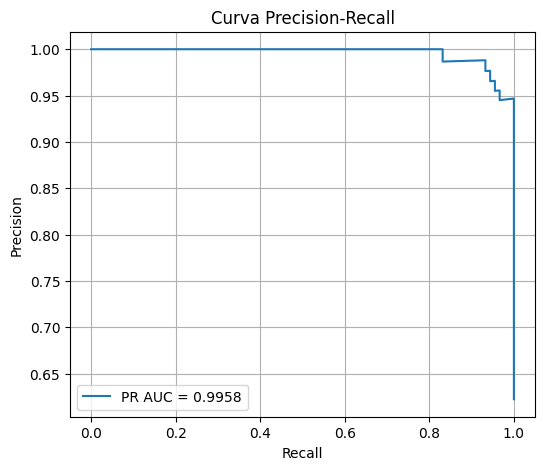

In [17]:
# Score
proba_test = model_fitted.predict(X_test_c)

# Métricas clásicas
auc_score = roc_auc_score(y_test, proba_test)
ll = log_loss(y_test, proba_test)

# Predicciones binarias con umbral 0.5
y_pred = (proba_test >= 0.5).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nMétricas (Test):")
print("AUC:", round(auc_score, 4)) #como de bien ordena mi modelo, metricas que veremos mas adelante con profundidad
print("LogLoss:", round(ll, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1-Score:", round(f1, 4))

# Curva Precision-Recall
prec, rec, thresholds = precision_recall_curve(y_test, proba_test)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import classification_report, balanced_accuracy_score

print("Reporte por clase:")
print(classification_report(y_test, y_pred, target_names=["maligno", "benigno"]))

bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", round(bal_acc, 4))

Reporte por clase:
              precision    recall  f1-score   support

     maligno       0.93      0.93      0.93        54
     benigno       0.96      0.96      0.96        89

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143

Balanced Accuracy: 0.9405


# 1.8 Interpretación de los parámetros

In [19]:
coef = model_fitted.params
odds = np.exp(coef)

table = pd.DataFrame({
    "coef": coef,
    "odds_ratio_exp(coef)": odds
}).sort_values("odds_ratio_exp(coef)", ascending=False)

print("\nCoeficientes y Odds Ratio (exp(coef)):")
print(table.round(3))

#los coeficientes se multiplican por la funcion sioidal, si un coef es positivo cuanto mas aumenta el radio mas probabilidad de que se de 1, 1 = benigno.
#¿mirando los coeficientes cuanto mas grande es el perimetro del tumor, mas benigno es? al estar correladas el radio y el perimetro, hacen un balance por eso es importante quitar una de ellas.


Coeficientes y Odds Ratio (exp(coef)):
                   coef  odds_ratio_exp(coef)
mean radius      19.906          4.415270e+08
const            -0.229          7.950000e-01
mean texture     -1.484          2.270000e-01
mean smoothness  -1.549          2.120000e-01
mean area       -13.105          0.000000e+00
mean perimeter  -13.520          0.000000e+00


### Interpretación de coeficientes en Logit (y por qué pueden “invertirse”)

En esta práctica, el modelo predice **P(target = 1)** y en el dataset de *Breast Cancer* **1 = benigno** y **0 = maligno**.

- **Coeficiente positivo (β > 0)**: al aumentar esa variable, **aumenta** la probabilidad de que el tumor sea **benigno** (clase 1), manteniendo el resto constante.
- **Coeficiente negativo (β < 0)**: al aumentar esa variable, **disminuye** la probabilidad de benigno (y por tanto “empuja” hacia **maligno**).

Al estandarizar las variables, el coeficiente se interpreta como el efecto de subir **1 desviación estándar** esa feature. Además, `exp(β)` es el **odds ratio**: un multiplicador de las *odds* de ser benigno.

#### ¿Por qué puede salir “radio +” y “perímetro −” y parecer raro?
Porque **radio, perímetro y área están muy correlacionados** (son distintas formas de medir el “tamaño”). Cuando incluimos varias variables casi equivalentes a la vez, el modelo no aprende “tamaño” en general, sino efectos **condicionales**:

#### Cómo hacerlo más interpretable
- Usar **solo una** de esas variables muy correlacionadas (por ejemplo, solo `mean radius` o solo `mean perimeter`).
- O usa **regularización** (Ridge/Lasso) para estabilizar coeficientes.

# 2. Ejemplo GLM Poisson (regresión)

## Práctica corta: GLM Poisson con `randhie` (visitas médicas)

### Contexto del dataset
`randhie` es un dataset (incluido en `statsmodels`) pensado para practicar **modelos de conteo**: la variable objetivo típica es `mdvis`, el **número de visitas al médico**.  
La idea de negocio/analítica es: *¿cómo cambian las visitas según el “precio”/diseño del seguro y según el estado de salud?*  
Por eso aparecen variables como coste compartido (`lncoins`) y variables de salud (`disea`, `physlm`, etc.).


## 2.1 Importamos librerías

In [21]:
#la idea es estimar cuantas visitas hacemos al medico
from statsmodels.datasets import randhie
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_poisson_deviance

## 2.2 Cargamos datos

In [22]:
# Cargar datos
df = randhie.load_pandas().data.copy()

## 2.3 Seleccionamos las features y el target

In [23]:
# Target (conteo)
y = df["mdvis"].astype(float)

# Features (elige pocas para que sea interpretable)
features = ["lncoins", "idp", "lpi", "physlm", "disea"]
X = df[features].copy()

In [25]:
X

,lncoins,idp,lpi,physlm,disea
0,4.615120,1,6.907755,0.000000,13.73189
1,4.615120,1,6.907755,0.000000,13.73189
2,4.615120,1,6.907755,0.000000,13.73189
3,4.615120,1,6.907755,0.000000,13.73189
4,4.615120,1,6.907755,0.000000,13.73189
...,...,...,...,...,...
20185,0.000000,0,5.377498,0.144292,10.57626
20186,0.000000,0,5.377498,0.144292,10.57626
20187,3.258096,0,6.874819,0.144292,10.57626
20188,3.258096,0,5.156178,0.144292,10.57626


## 2.4 EDA

Shape: (20190, 10)

mdvis (conteo) resumen:
count    20190.000000
mean         2.860426
std          4.504365
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max         77.000000
Name: mdvis, dtype: float64

% ceros en mdvis: 31.24 %

Nulos en X:
lncoins    0
idp        0
lpi        0
physlm     0
disea      0
dtype: int64


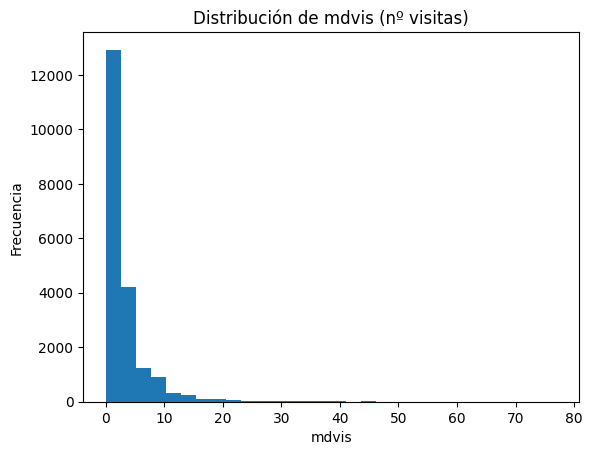

In [26]:
print("Shape:", df.shape)
print("\nmdvis (conteo) resumen:")
print(y.describe())
print("\n% ceros en mdvis:", round((y == 0).mean() * 100, 2), "%")

print("\nNulos en X:")
print(X.isna().sum())

# Histograma rápido del conteo (suele estar sesgado con muchos ceros)
plt.figure()
plt.hist(y, bins=30)
plt.title("Distribución de mdvis (nº visitas)")
plt.xlabel("mdvis")
plt.ylabel("Frecuencia")
plt.show()

## 2.5 Entrenamiento

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train_c = sm.add_constant(X_train, has_constant="add")
X_test_c  = sm.add_constant(X_test,  has_constant="add")

# GLM Poisson (link log por defecto)
model = sm.GLM(y_train, X_train_c, family=sm.families.Poisson())
fit = model.fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  mdvis   No. Observations:                15142
Model:                            GLM   Df Residuals:                    15136
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46573.
Date:                Wed, 04 Feb 2026   Deviance:                       62618.
Time:                        20:36:03   Pearson chi2:                 9.35e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3213
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6698      0.013     53.323      0.0

## 2.6 Evaluación

In [28]:
# Predicciones + métricas
pred = fit.predict(X_test_c)

print("\nMAE:", round(mean_absolute_error(y_test, pred), 3))
print("Mean Poisson Deviance:", round(mean_poisson_deviance(y_test, pred), 3))

# Interpretación: exp(coef) = multiplicador del conteo esperado
coefs = fit.params
mult = np.exp(coefs)
out = pd.DataFrame({"coef": coefs, "exp(coef)": mult}).sort_values("exp(coef)", ascending=False)

print("\nMultiplicadores (exp(coef)):")
print(out.round(3))


MAE: 2.631
Mean Poisson Deviance: 4.329

Multiplicadores (exp(coef)):
          coef  exp(coef)
const    0.670      1.954
physlm   0.277      1.319
disea    0.035      1.036
lpi      0.025      1.025
lncoins -0.090      0.913
idp     -0.301      0.740


| Variable  | coef    | Exp(coef) | Interpretación                                                                                                  |
| --------- | ------- | --------- | --------------------------------------------------------------------------------------------------------------- |
| `const`   | 0.6698  | 1.954     | Media base de `mdvis` cuando todas las demás variables son 0: (E[Y] = e^{0.6698} \approx 1.95)                  |
| `lncoins` | -0.0905 | 0.913     | Por cada unidad extra en `lncoins`, el **conteo esperado** de `mdvis` se multiplica por 0.913 → disminuye ~8.7% |
| `idp`     | -0.3006 | 0.740     | Por cada unidad extra en `idp`, el conteo esperado se reduce ~26%                                               |
| `lpi`     | 0.0245  | 1.025     | Cada unidad extra en `lpi` aumenta el conteo esperado ~2.5%                                                     |
| `physlm`  | 0.2767  | 1.319     | Cada unidad extra en `physlm` aumenta el conteo esperado ~32%                                                   |
| `disea`   | 0.0355  | 1.036     | Cada unidad extra en `disea` aumenta el conteo esperado ~3.6%                                                   |
